# Aggregating manual annotations and correlations

We read the evaluation results from excel files that have the following columns:

Turn	
Speaker	
Cue	
Response	
Context

System ratings
* MLM response	
* System llh	
* MLM llh	
* USR DLcontext	
* USR DLfact	

Human ratings:
* Overall Human Rating	
* Interesting	
* Engaging	
* Specific	
* Relevant	
* Correct	
* Semantically Appropriate	
* Understandable	
* Fluent

In [9]:
# Needed to calculate the mean square error for regression scores
#! pip install sklearn

In [10]:
### Needed to read Ecel files: xlsx
# ! pip install openpyxl

In [49]:
from pathlib import Path
import glob
import pandas as pd
import json
import math
import numpy as np
import matplotlib.pyplot as plt

#group = "g1-piek"
#group = "g2-jaap"
#group = "g3-lea"
group = "g4-tae"
annotation_path = "/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/"+group+"/scenario2"
#annotation_path = "."
basepath = Path(annotation_path)

In [50]:
def get_score_triples_from_turn(json_row:str, speaker_scores:{}, auto_score:str, hum_score:str):
    speaker = json_row['Speaker']
    turn = json_row['Turn']
    auto = json_row[auto_score]
    hum = json_row[hum_score]
    triple = (turn, auto, hum)
    if not speaker_scores.get(speaker):
        speaker_scores[speaker]=[]
    speaker_scores[speaker].append(triple)
    
def evaluate_regression_scores(basepath:Path, speaker_scores:{},auto_score:str, hum_score:str):
    turn_index =[]
    speaker_scores:{}
    for path in basepath.glob('*.csv'):
        df = pd.read_csv(path)
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            get_score_triples_from_turn(turn, speaker_scores, auto_score,hum_score)

def get_scores_for_turns(json_row:str, turn_scores:{}, score_name:str):
    turn = json_row['Turn']
    score = json_row[score_name]
    if score:
        if not turn_scores.get(turn):
            turn_scores[turn]=[]
        turn_scores[turn].append(score)

def get_score_for_turns(json_row:str, turn_scores:{}, score_name:str):
    turn = json_row['Turn']
    score = json_row[score_name]
    if score:
        turn_scores[turn]= score

def get_normalized_human_scores(basepath:Path, score_name:str):
    all_turn_scores = {}
    normalized_scores = {}
    averaged_score = []
    for path in basepath.glob('*.csv'):
        df = pd.read_csv(path)
        if 'Turn' in df:
            print(path)
            js = df.to_json(orient = 'records')
            turn_scores={}
            for turn in json.loads(js):
                get_scores_for_turns(turn, turn_scores, score_name)
            for turn_id in turn_scores:
                if not all_turn_scores.get(turn_id):
                    all_turn_scores[turn_id]=[]
                all_turn_scores[turn_id].extend(turn_scores[turn_id])

    for turn_id in all_turn_scores:
        scores = all_turn_scores[turn_id]
        average = sum(scores)/len(scores)
        averaged_score.append(average)
        normalized_score = (average-1)/4
        normalized_scores[turn_id]=normalized_score
    averaged_score = sum(averaged_score)/len(averaged_score)
    #print(normalized_scores)
    #print(averaged_score)
    return normalized_scores, averaged_score

## Averaging the human annotations 

In [51]:
score_name = "Overall Human Rating"
normalized_scores_overall, average_overall = get_normalized_human_scores(basepath, score_name)

score_name = "Interesting"
normalized_scores_interesting, average_interesting = get_normalized_human_scores(basepath, score_name)

score_name = "Engaging"
normalized_scores_engaging, average_engaging = get_normalized_human_scores(basepath, score_name)

score_name = "Specific"
normalized_scores_specific, average_specific = get_normalized_human_scores(basepath, score_name)

score_name = "Relevant"
normalized_scores_relevant, average_relevant = get_normalized_human_scores(basepath, score_name)

score_name = "Correct"
normalized_scores_correct, average_correct = get_normalized_human_scores(basepath, score_name)

score_name = "Semantically Appropriate"
normalized_scores_semantic, average_semantic = get_normalized_human_scores(basepath, score_name)

score_name = "Understandable"
normalized_scores_understandable, average_understand = get_normalized_human_scores(basepath, score_name)

score_name = "Fluent"
normalized_scores_fluent, average_fluent = get_normalized_human_scores(basepath, score_name)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g4-tae/scenario2/nicole_2 - 2021-12-10-09_23_53_turns10_context300.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g4-tae/scenario2/nihed -2 - 2021-12-10-09_23_53_turns10_context300.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g4-tae/scenario2/Fajjaaz - 2 - 2021-12-10-09_23_53_turns10_context300.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g4-tae/scenario2/Hidde_2.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g4-tae/scenario2/nicole_2 - 2021-12-10-09_23_53_turns10_context300.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g4-tae/scenario2/nihed -2 - 2021-12-10-09_23_53_turns10_context300.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g4-tae/scenario2/Fajjaaz - 2 - 2021-12-10-09_23_53_turns10_context300.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/

In [52]:
print(average_overall)
print(average_interesting)
print(average_engaging)
print(average_specific)
print(average_relevant)
print(average_correct)
print(average_semantic)
print(average_understand)
print(average_fluent)

2.1233974358974357
1.9134615384615385
2.219551282051282
2.020833333333333
2.251602564102564
2.2019230769230766
2.2724358974358974
2.9727564102564097
3.076923076923077


### Visualising the human ratings over turns

In [20]:
def extend__with_bar(width, normalized_scores:{}, score_name:str, plt, colors:[], used_colors):
    turns = list(normalized_scores.keys())
    ###We take all turns from the turn_index to create the x-axis
    x = np.arange(len(turns))
    y = []
    for key in normalized_scores:
        y.append(normalized_scores[key])
    c1 = choice(colors)   
    while c1 in used_colors:
        c1 = choice(colors)
    
    used_colors.append(c1)
    plt.barh(x+width, y,  color=c1, edgecolor="black", label=score_name, height=0.1)
    #plt.bar(x+width, y,  color=c1, width=barWidth, edgecolor="black", label=score_name)

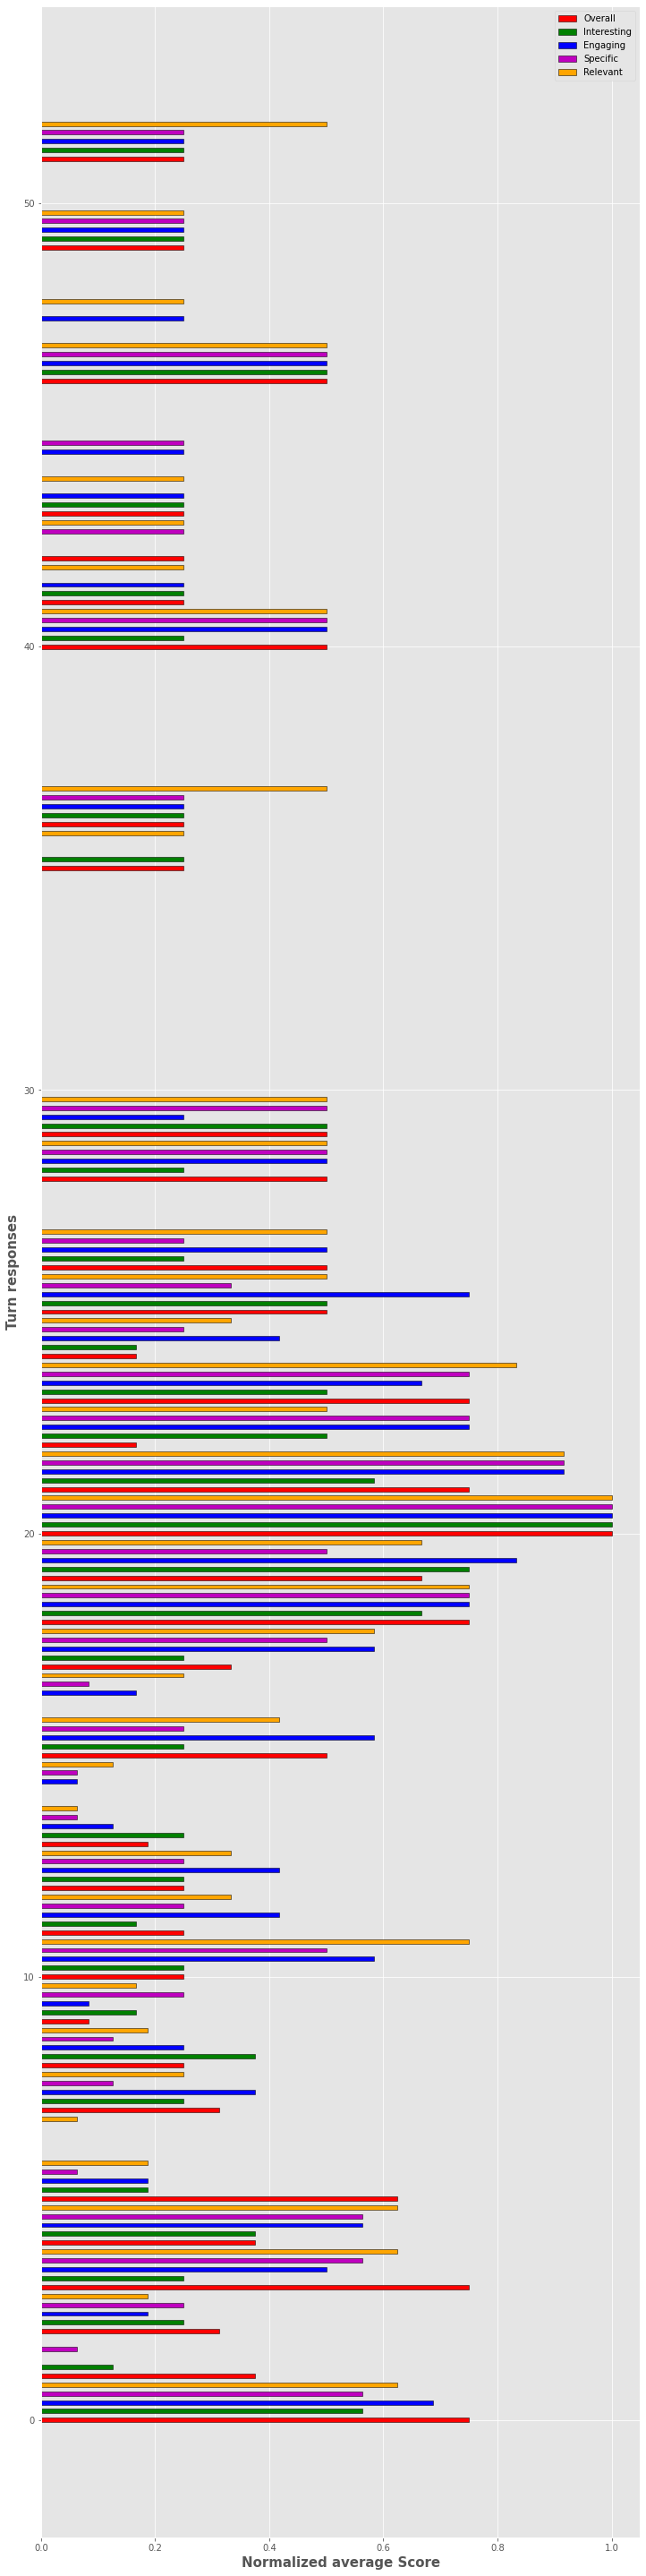

In [21]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

score_name = "Overall"
extend__with_bar(0, normalized_scores_overall, score_name, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, colors, used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, colors, used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, colors, used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, colors, used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

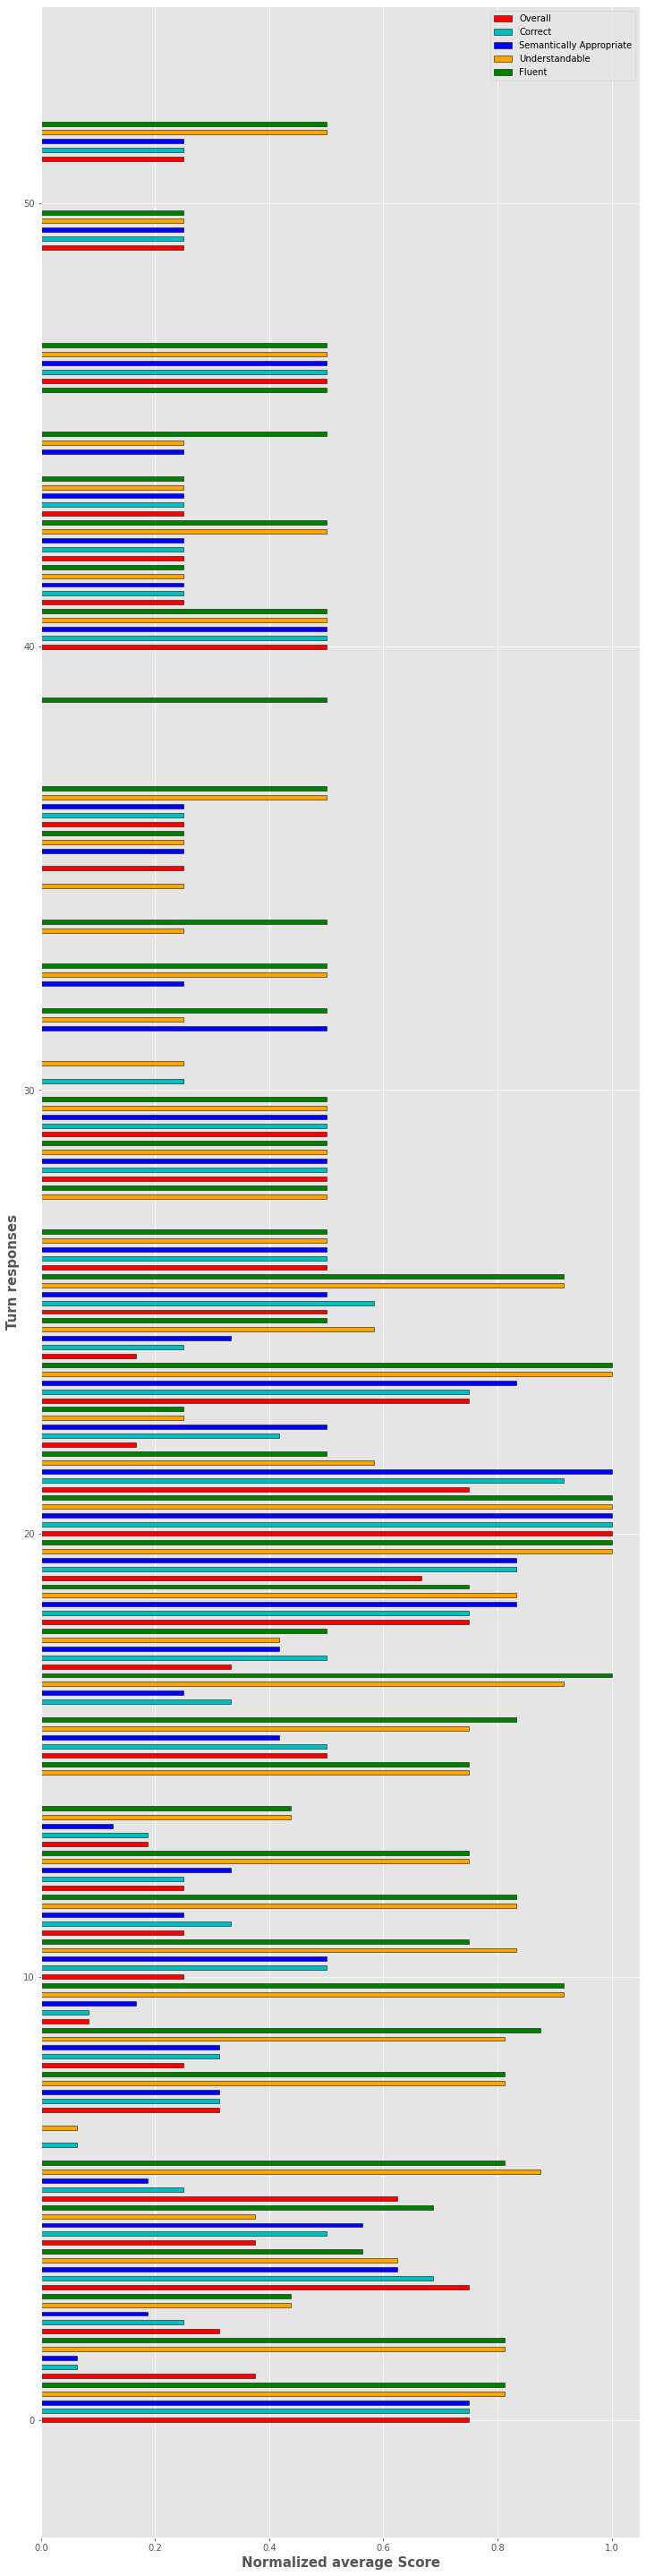

In [22]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

score_name = "Overall"
extend__with_bar(0, normalized_scores_overall, score_name, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, colors, used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, colors, used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, colors, used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, colors, used_colors)

plt.style.use('ggplot')
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

### Correlating the human annotations with overall rating

In [23]:
#https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e

from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_mean_error_area(scores_x, scores_y):
    x = []
    for key in scores_x:
        x.append(scores_x[key])
    y = []
    for key in scores_y:
        y.append(scores_y[key])

    dif=(len(x)-len(y))
    if dif>0:
        for i in range(dif):
            y.append(0)
    if dif<0:
        for i in range(dif*-1):
            x.append(0)
            
    #print(score_name_x, "&", score_name_y)
    mae = mean_absolute_error(x, y).round(2)
    mse = mean_squared_error(x, y).round(2)
    rmse = mean_squared_error(x, y, squared=False).round(2)
    #print(f"Mean Absolute Error:", mae)
    #print(f"Mean Squared Error:", mse)
    #print(f"Root Mean Squared Error:", rmse)
    return mae, mse, rmse

In [24]:
rows = []
score_name_x = "Overall Human Rating"

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_interesting)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_engaging)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_engaging)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_relevant)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_correct)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_semantic)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_understandable)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_fluent)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_scores = pd.DataFrame(rows)
df_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_scores.to_csv(file, index=False)

## Correlating automated score with the human ratings

### System likelihood of the agent answers

In [29]:
score_name_x = "System llh"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files


for path in basepath.glob('Hidde_2.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g4-tae/scenario2/Hidde_2.csv
52 {4: 0.5643311031, 6: 0.5307367729, 8: 0.0145826705, 10: 0.3262576666, 12: 0.5752556819, 14: 0.3662408353, 16: 0.3556039759, 18: 0.7996719182, 19: 0.5199348398, 21: 0.3946560306, 23: 0.3916450345, 25: 0.3109612098, 27: 0.5702283409, 29: 0.7108607938, 41: 0.2418006426, 43: 0.1374273708, 45: 0.4135493977, 47: 0.1701798892, 49: 0.5826518566, 51: 0.4235467661, 53: 0.5348599842, 55: 0.1981981198, 57: 0.4278944191, 59: 0.50940273, 64: 0.6183350931, 66: 0.2643175969, 68: 0.2922382454, 70: 0.8533892844, 72: 0.3482664656, 74: 0.2466588045, 81: 0.5244670719, 83: 0.2179155216, 85: 0.3194262891, 87: 0.5515205083, 89: 0.3075298449, 91: 0.4767141279, 31: 0, 33: 0, 35: 0, 37: 0, 39: 0, 50: 0, 52: 0, 54: 0, 56: 0, 58: 0, 65: 0, 67: 0, 69: 0, 71: 0, 73: 0, 75: 0}
52 {6: 0.75, 8: 0.375, 10: 0.3125, 12: 0.75, 14: 0.375, 16: 0.625, 25: 0.0, 27: 0.3125, 29: 0.25, 31: 0.08333333333333331, 33: 0.25, 35: 0.25,

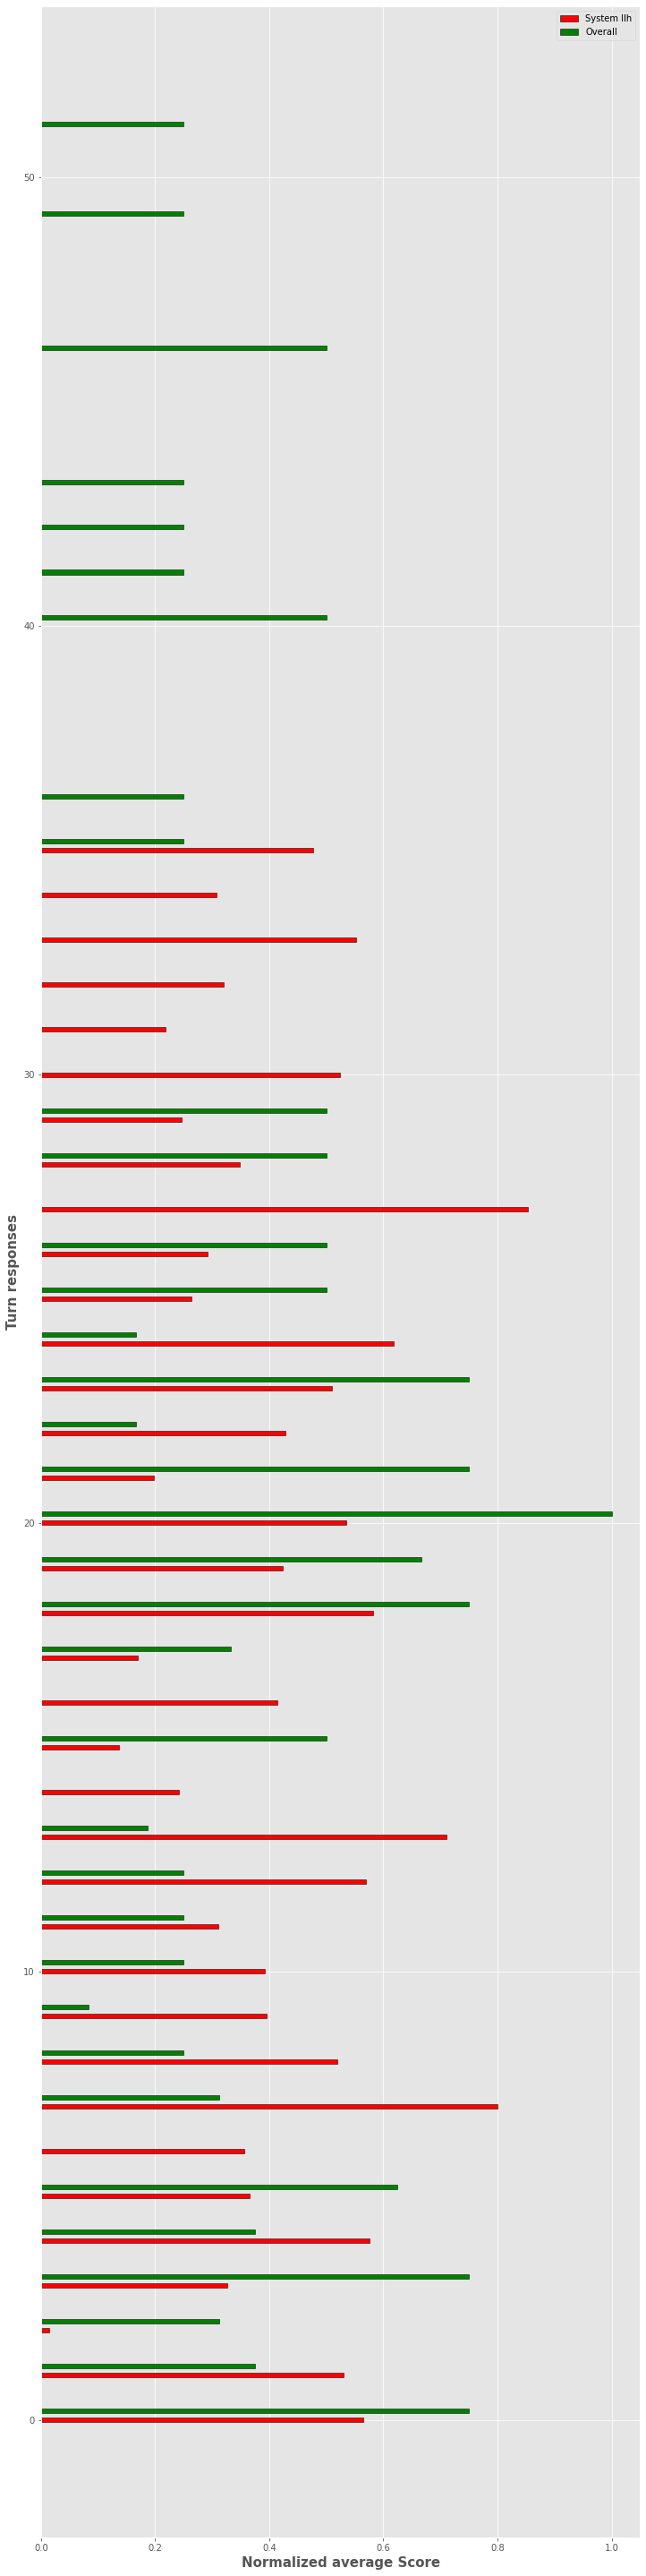

In [30]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()


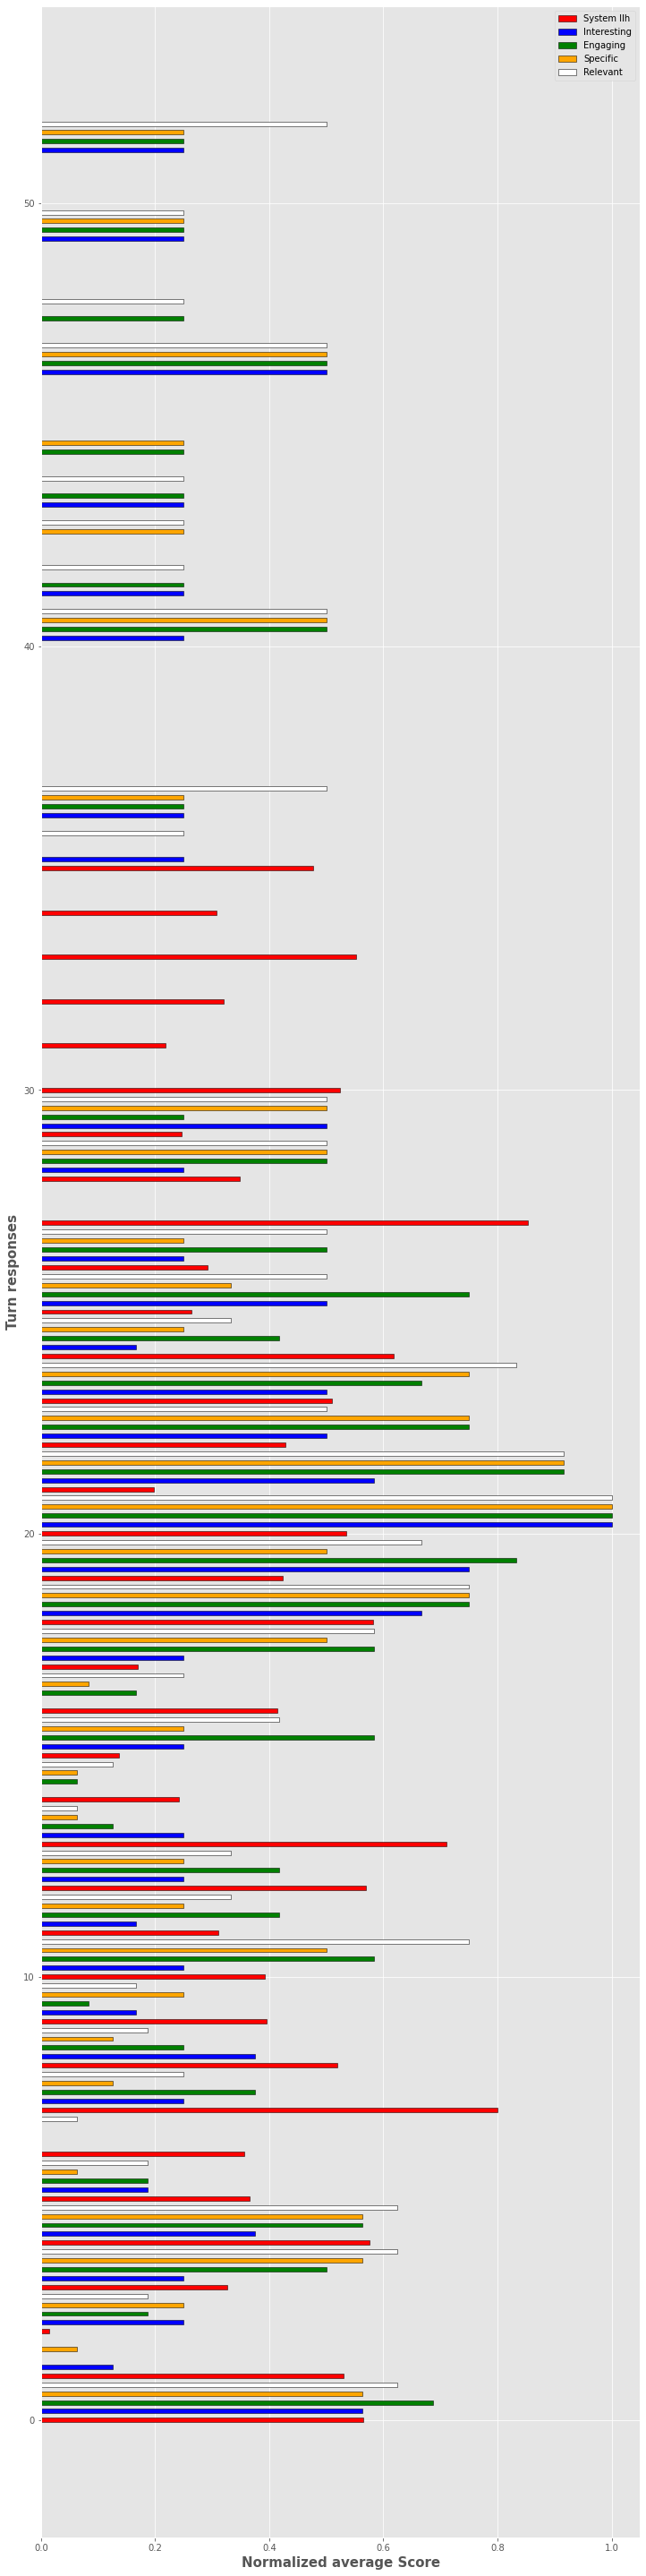

In [31]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)


score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)


plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()



In [32]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})



df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### MLM likelihood of the language model

In [34]:
score_name_x = "MLM llh"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('Hidde_2.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

# Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)


/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g4-tae/scenario2/Hidde_2.csv
52 {4: 0.7710111613, 6: 0.778833178, 8: 0.3301391439, 10: 0.5825735898, 12: 0.7005784313, 14: 0.5477085124, 16: 0.4968589757, 18: 0.7996719182, 19: 0.6741645008, 21: 0.7346600358, 23: 0.6204900311, 25: 0.6321953929, 27: 0.7809051233, 29: 0.7434346899, 39: 0.7126688957, 41: 0.5148616912, 43: 0.5333777107, 45: 0.5405738418, 47: 0.411615296, 49: 0.8376209864, 51: 0.6400171492, 53: 0.6917421333, 55: 0.3976115278, 57: 0.5834464878, 59: 0.6509329385, 64: 0.7786557712, 66: 0.5976452524, 68: 0.5493519803, 70: 0.9650758718, 72: 0.6030084963, 74: 0.4324657718, 81: 0.661293757, 83: 0.504037865, 85: 0.6322107799, 87: 0.7402706041, 89: 0.5960002946, 91: 0.81128324, 31: 0, 33: 0, 35: 0, 37: 0, 50: 0, 52: 0, 54: 0, 56: 0, 58: 0, 65: 0, 67: 0, 69: 0, 71: 0, 73: 0, 75: 0}
52 {6: 0.75, 8: 0.375, 10: 0.3125, 12: 0.75, 14: 0.375, 16: 0.625, 25: 0.0, 27: 0.3125, 29: 0.25, 31: 0.08333333333333331, 33: 0.25, 35

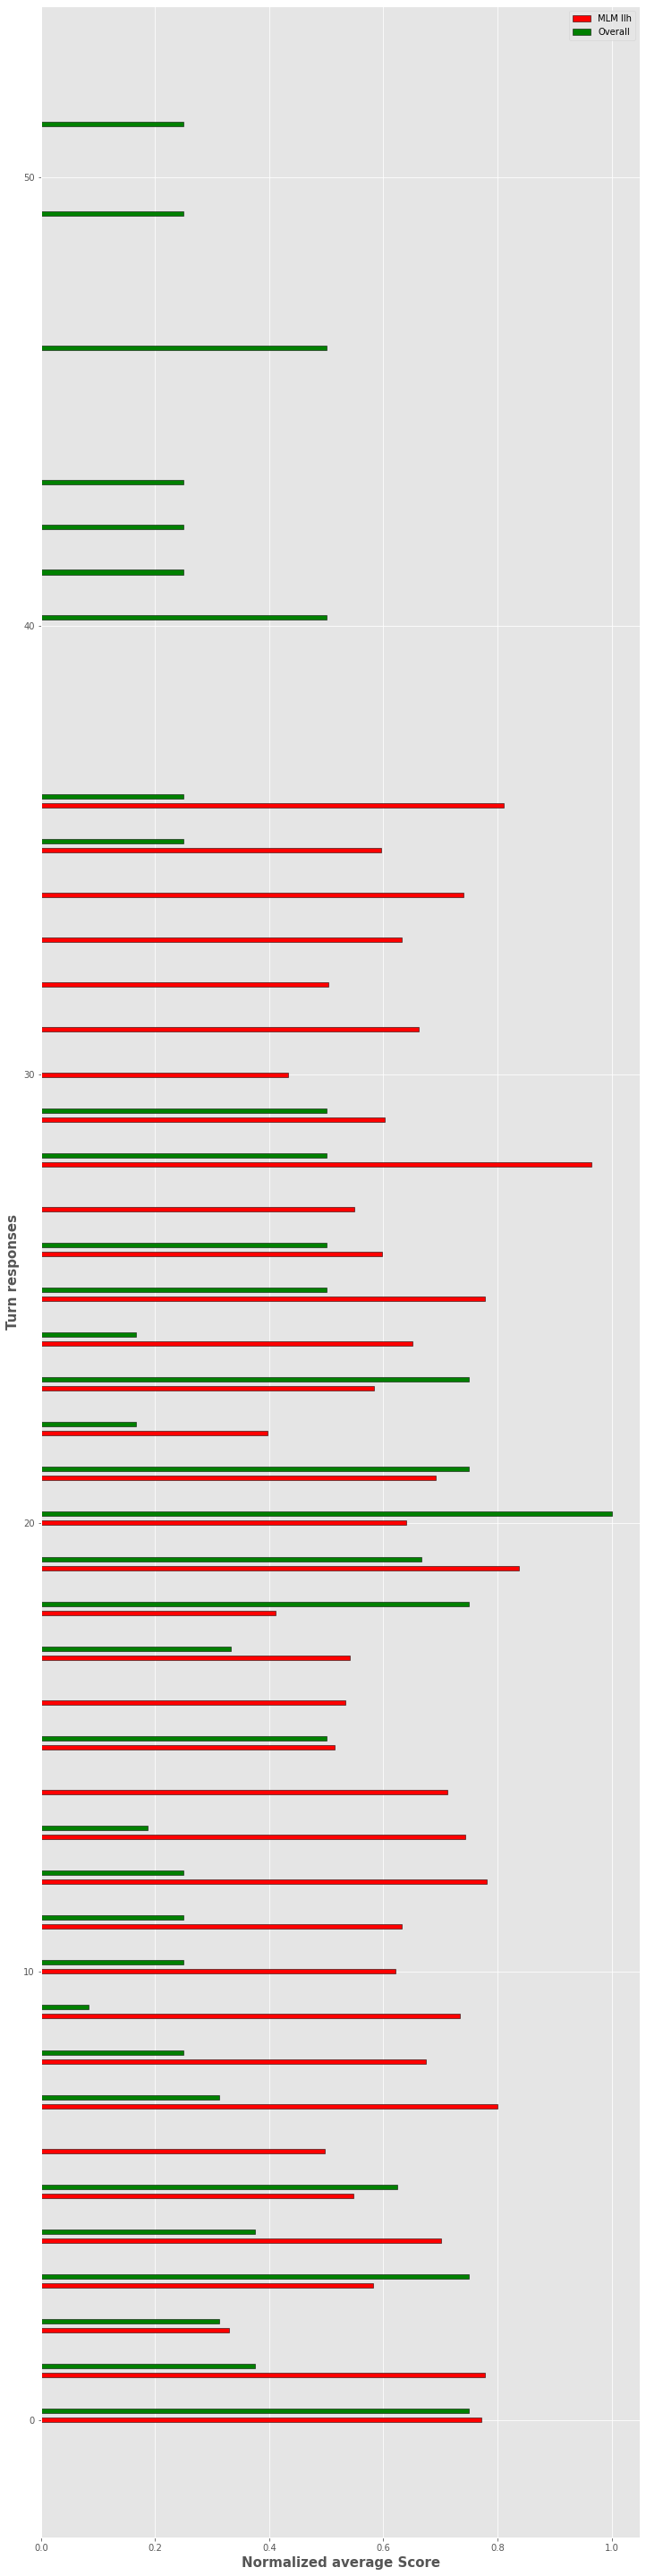

In [35]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

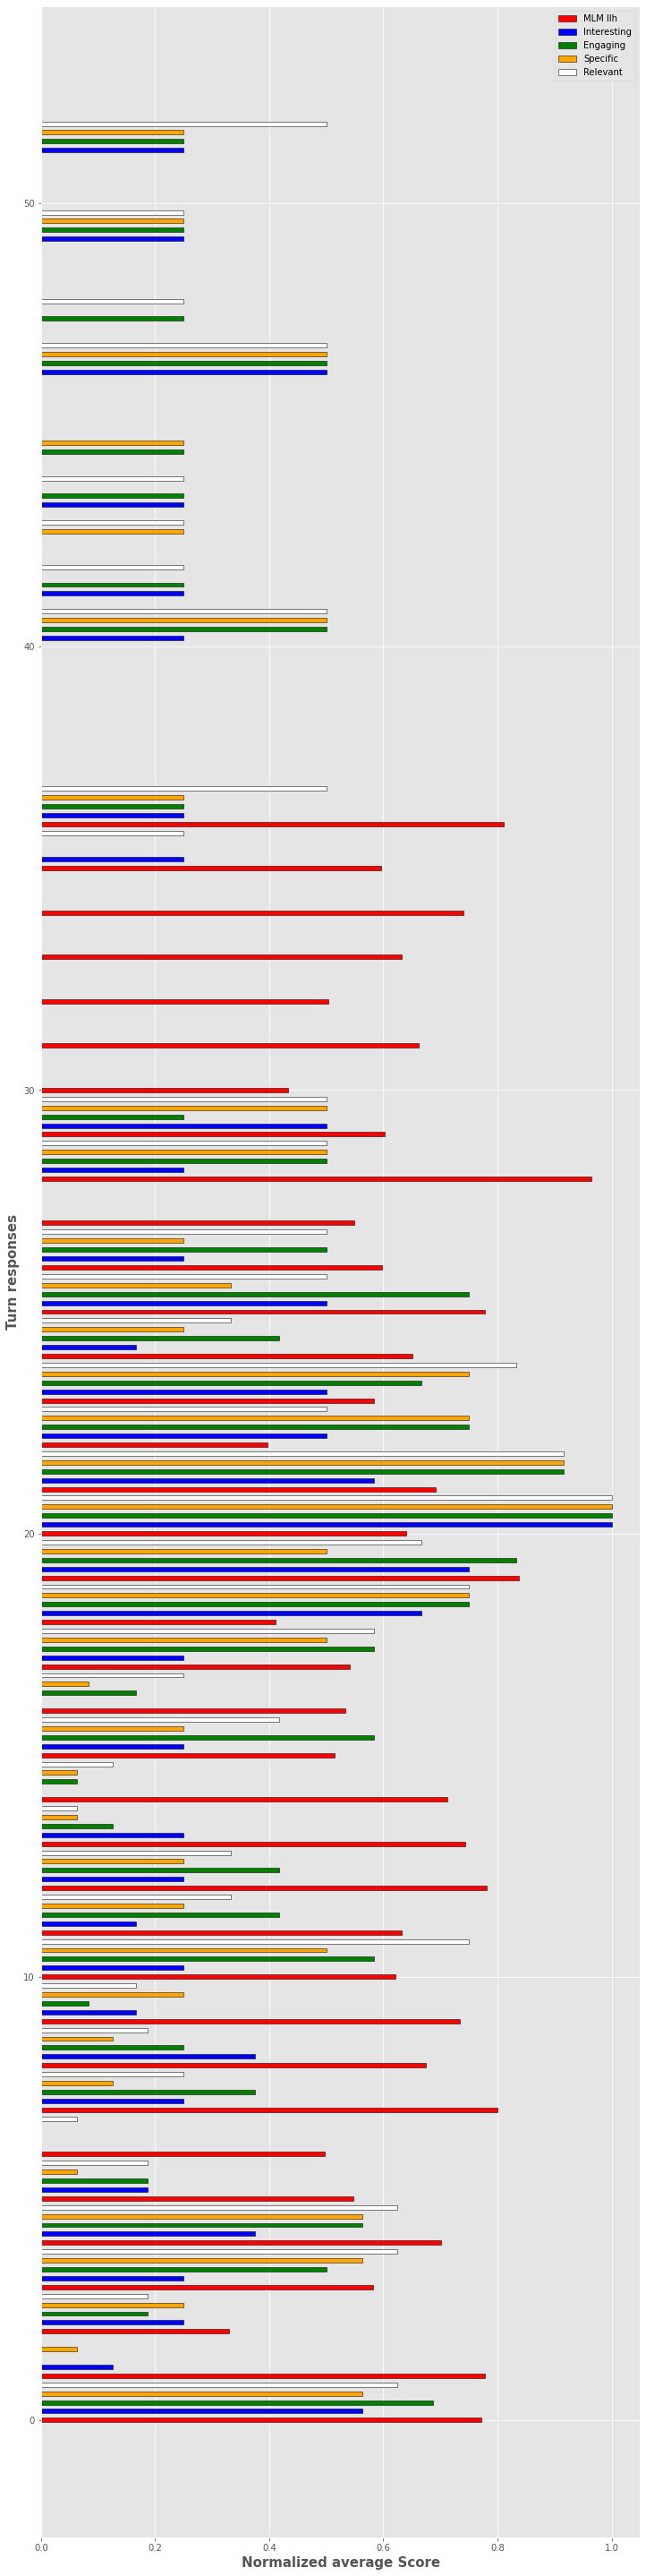

In [36]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

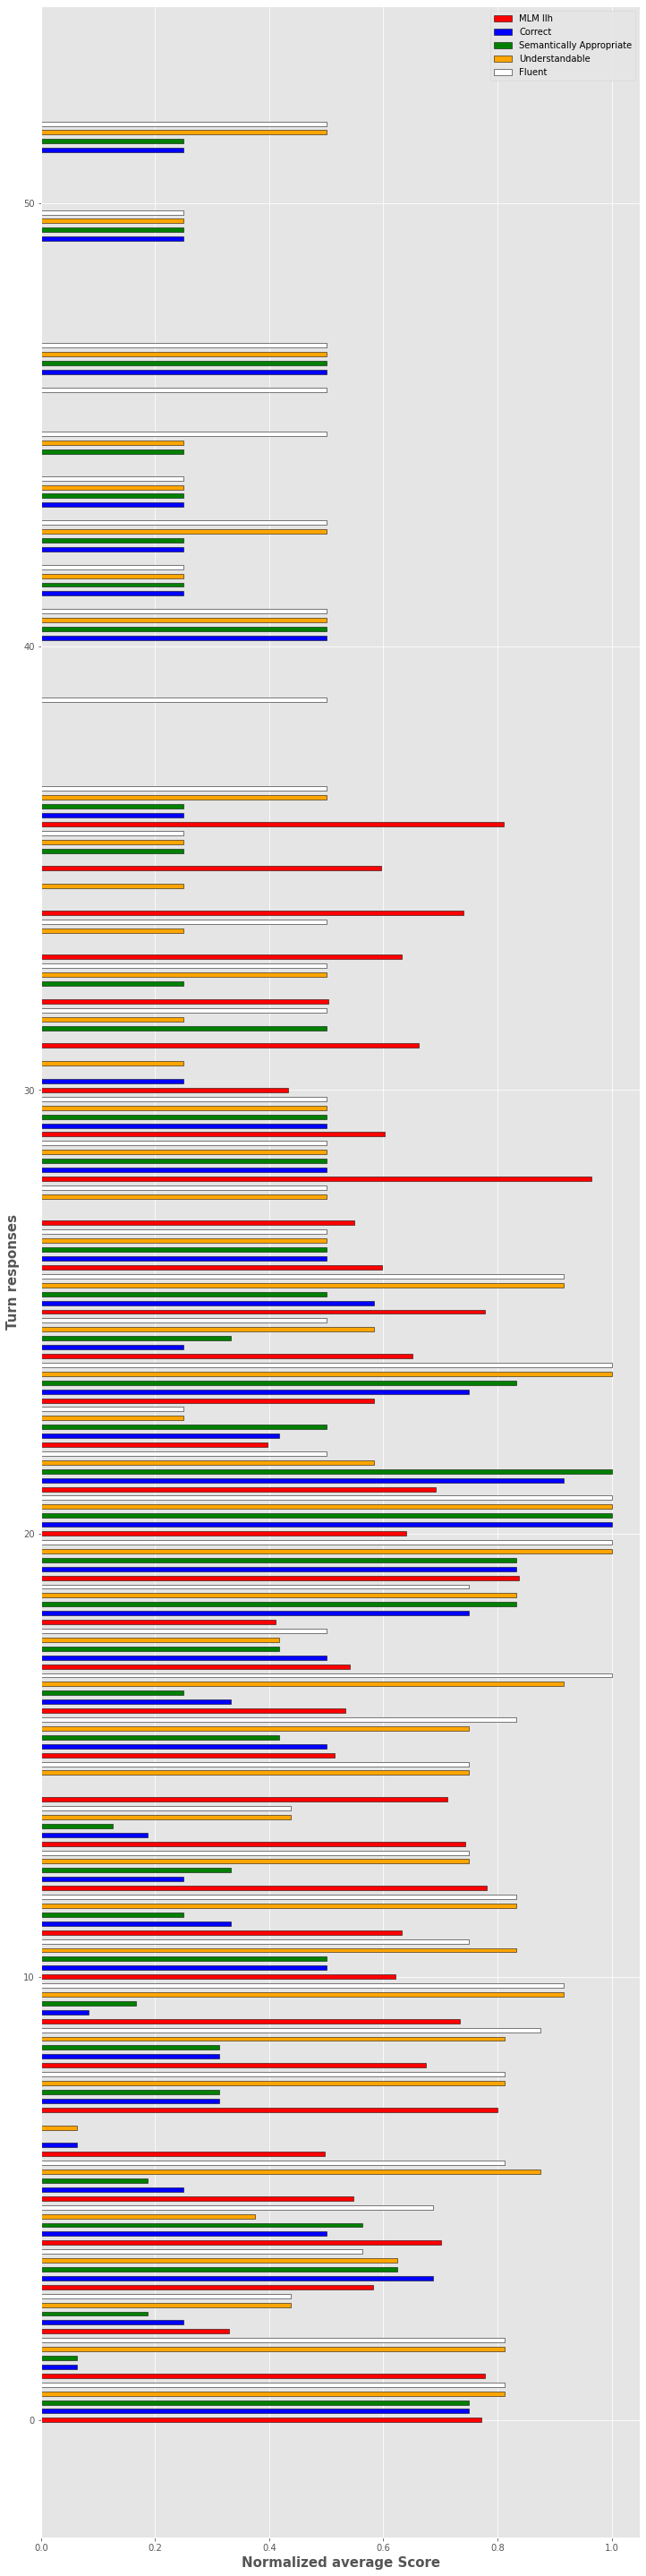

In [37]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [38]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### USR DLcontext

In [39]:
score_name_x = "USR DLcontext"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('Hidde_2.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g4-tae/scenario2/Hidde_2.csv
52 {4: 0.98693943, 6: 0.9983044, 8: 0.5716542, 10: 0.8741282, 12: 0.9980145, 14: 0.9969412, 16: 0.9980218, 18: 0.98482734, 19: 0.93975943, 21: 0.7533641, 23: 0.9418879, 25: 0.99198425, 27: 0.99781996, 29: 0.99504125, 39: 0.9902405, 41: 0.98048085, 43: 0.12004683, 45: 0.9938488, 47: 0.05899847, 49: 0.9980303, 51: 0.99604815, 53: 0.010720053, 55: 0.007887302, 57: 0.089175105, 59: 0.08740096, 64: 0.011167788, 66: 0.019581133, 68: 0.9971593, 70: 0.99804014, 72: 0.998349, 74: 0.9984343, 81: 0.87710845, 83: 0.99208444, 85: 0.99498546, 87: 0.99631405, 89: 0.9912217, 91: 0.9976113, 31: 0, 33: 0, 35: 0, 37: 0, 50: 0, 52: 0, 54: 0, 56: 0, 58: 0, 65: 0, 67: 0, 69: 0, 71: 0, 73: 0, 75: 0}
52 {6: 0.75, 8: 0.375, 10: 0.3125, 12: 0.75, 14: 0.375, 16: 0.625, 25: 0.0, 27: 0.3125, 29: 0.25, 31: 0.08333333333333331, 33: 0.25, 35: 0.25, 37: 0.25, 39: 0.1875, 41: 0.0, 50: 0.5, 52: 0.0, 54: 0.33333333333333337

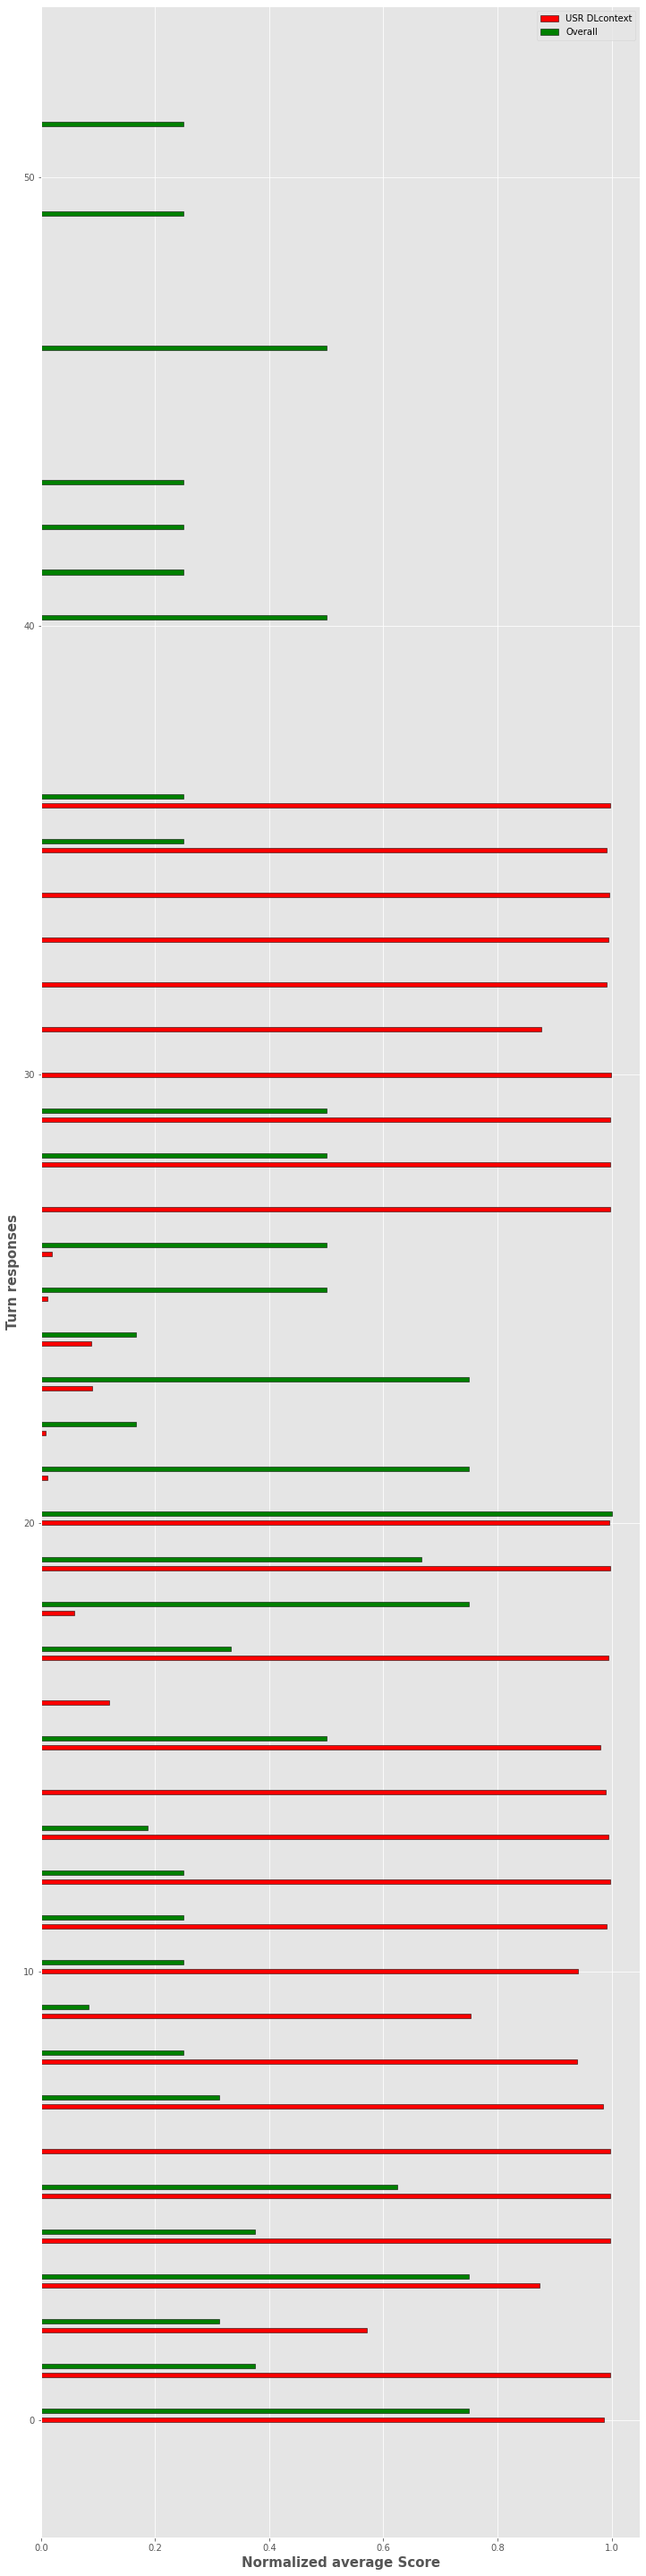

In [40]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

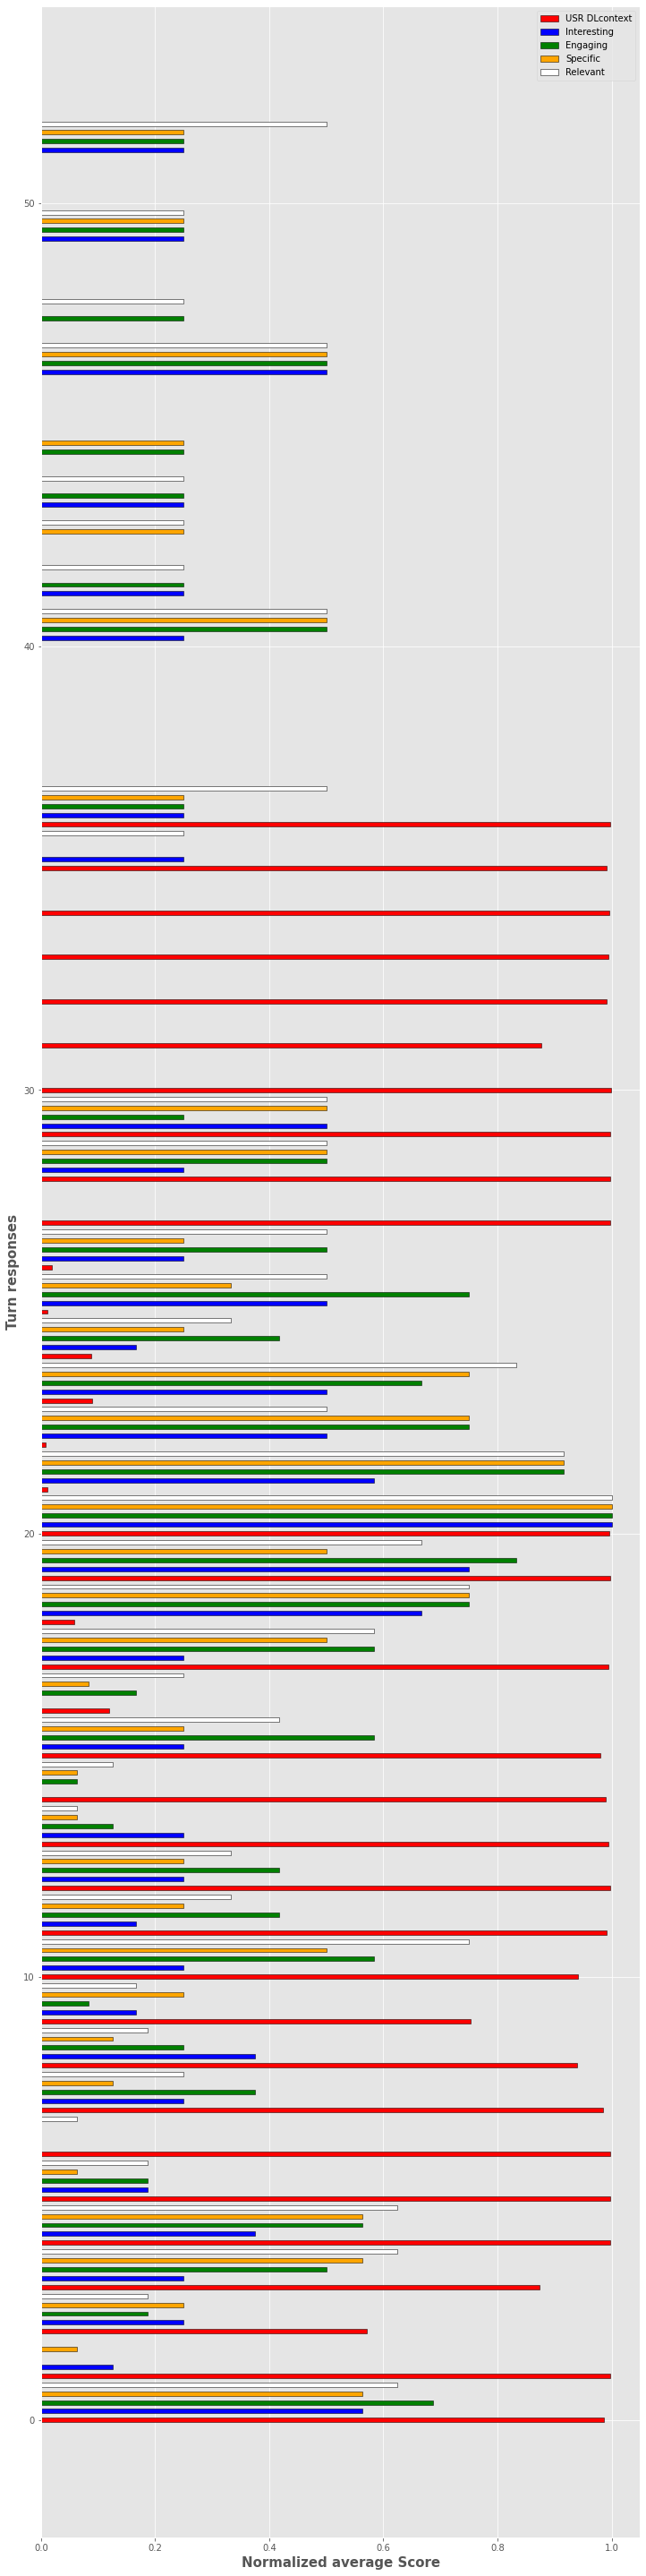

In [41]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

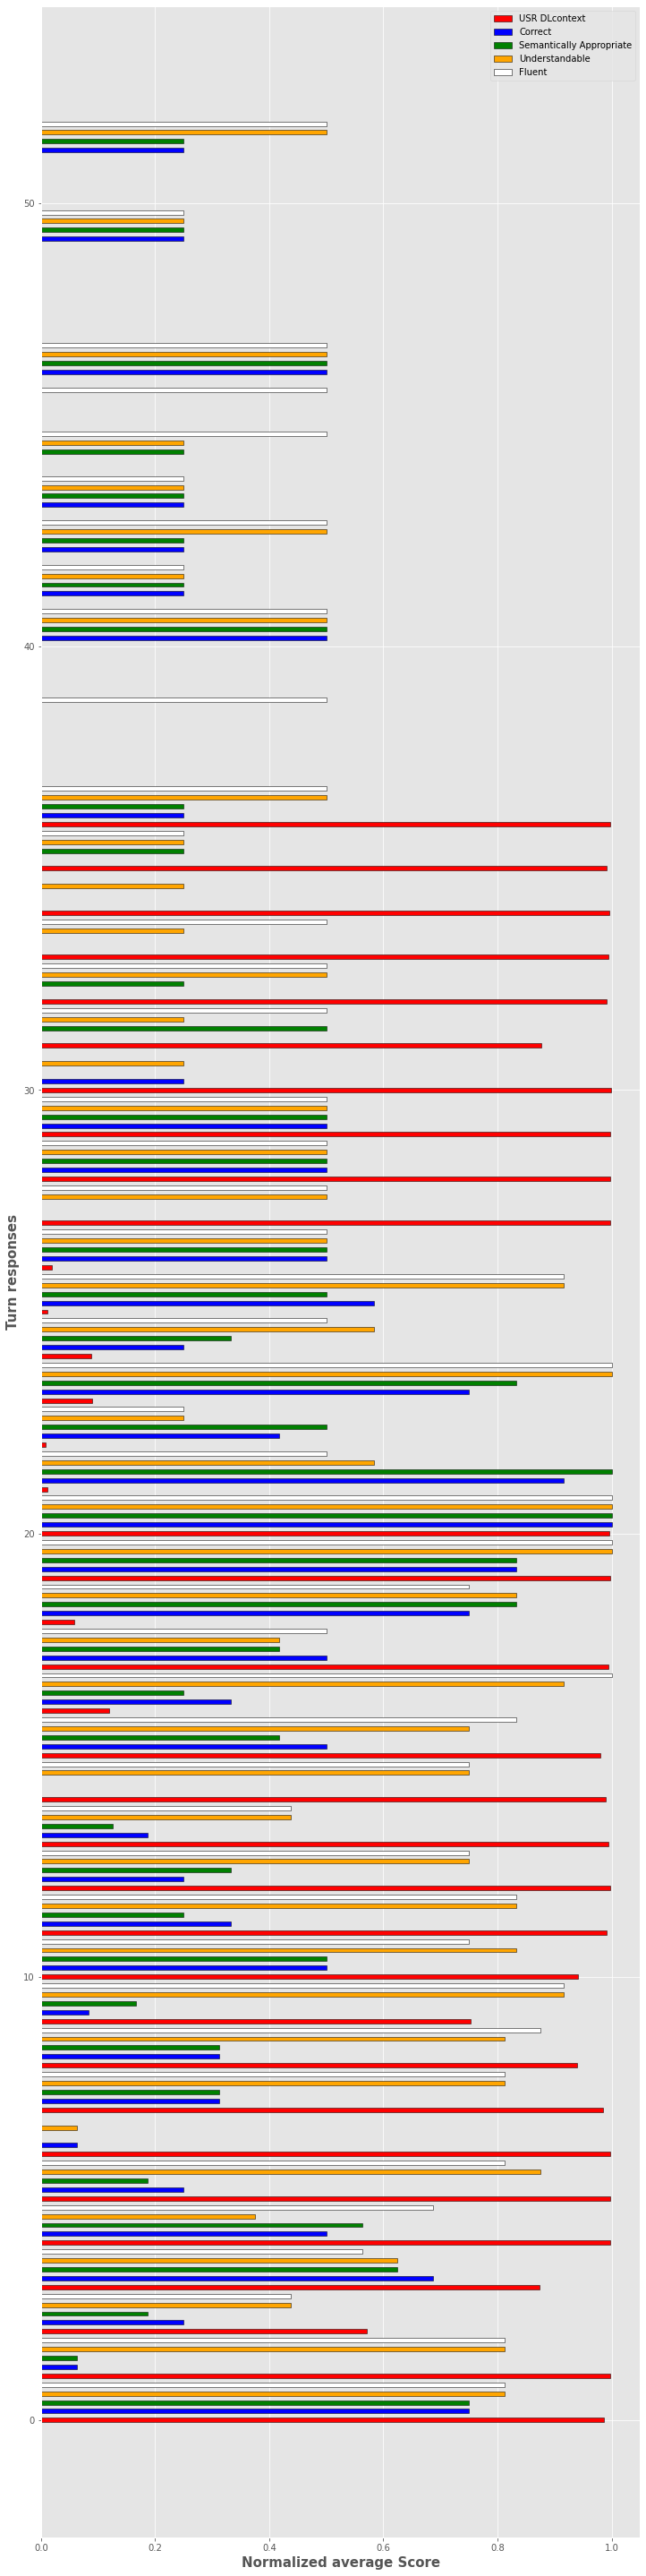

In [42]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [43]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### USR DLfact

In [44]:
score_name_x = "USR DLfact"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('Hidde_2.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)



/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g4-tae/scenario2/Hidde_2.csv
52 {4: 0.75663704, 6: 0.067590795, 8: 0.054469716, 10: 0.1336669, 12: 0.9961675, 14: 0.9701655, 16: 0.9941512, 18: 0.99637085, 19: 0.6608756, 21: 0.33404097, 23: 0.6536772, 25: 0.99578696, 27: 0.9960652, 29: 0.98734003, 39: 0.6019097, 41: 0.6895107, 43: 0.70479584, 45: 0.13862288, 47: 0.024742017, 49: 0.99717796, 51: 0.9954416, 53: 0.6692366, 55: 0.03793796, 57: 0.118496284, 59: 0.6369001, 64: 0.69278693, 66: 0.3657113, 68: 0.82680976, 70: 0.44174537, 72: 0.542596, 74: 0.99706376, 81: 0.95688033, 83: 0.99674654, 85: 0.970086, 87: 0.9966041, 89: 0.99415666, 91: 0.70313364, 31: 0, 33: 0, 35: 0, 37: 0, 50: 0, 52: 0, 54: 0, 56: 0, 58: 0, 65: 0, 67: 0, 69: 0, 71: 0, 73: 0, 75: 0}
52 {6: 0.75, 8: 0.375, 10: 0.3125, 12: 0.75, 14: 0.375, 16: 0.625, 25: 0.0, 27: 0.3125, 29: 0.25, 31: 0.08333333333333331, 33: 0.25, 35: 0.25, 37: 0.25, 39: 0.1875, 41: 0.0, 50: 0.5, 52: 0.0, 54: 0.33333333333333337, 

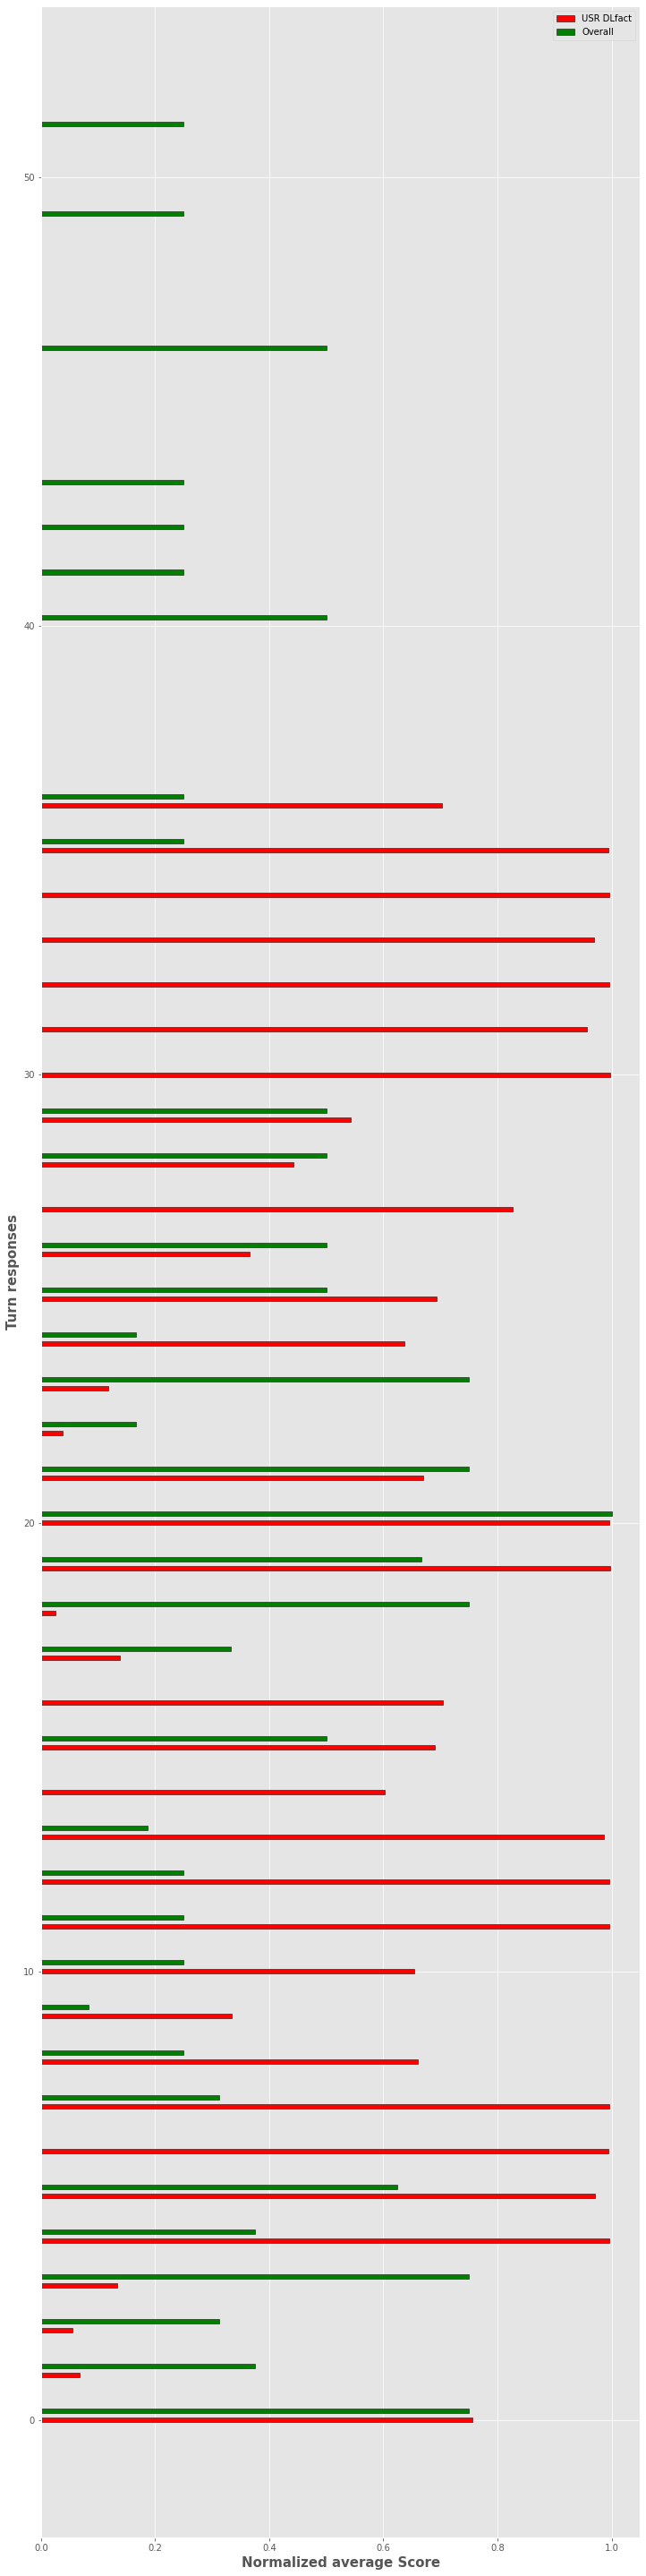

In [45]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

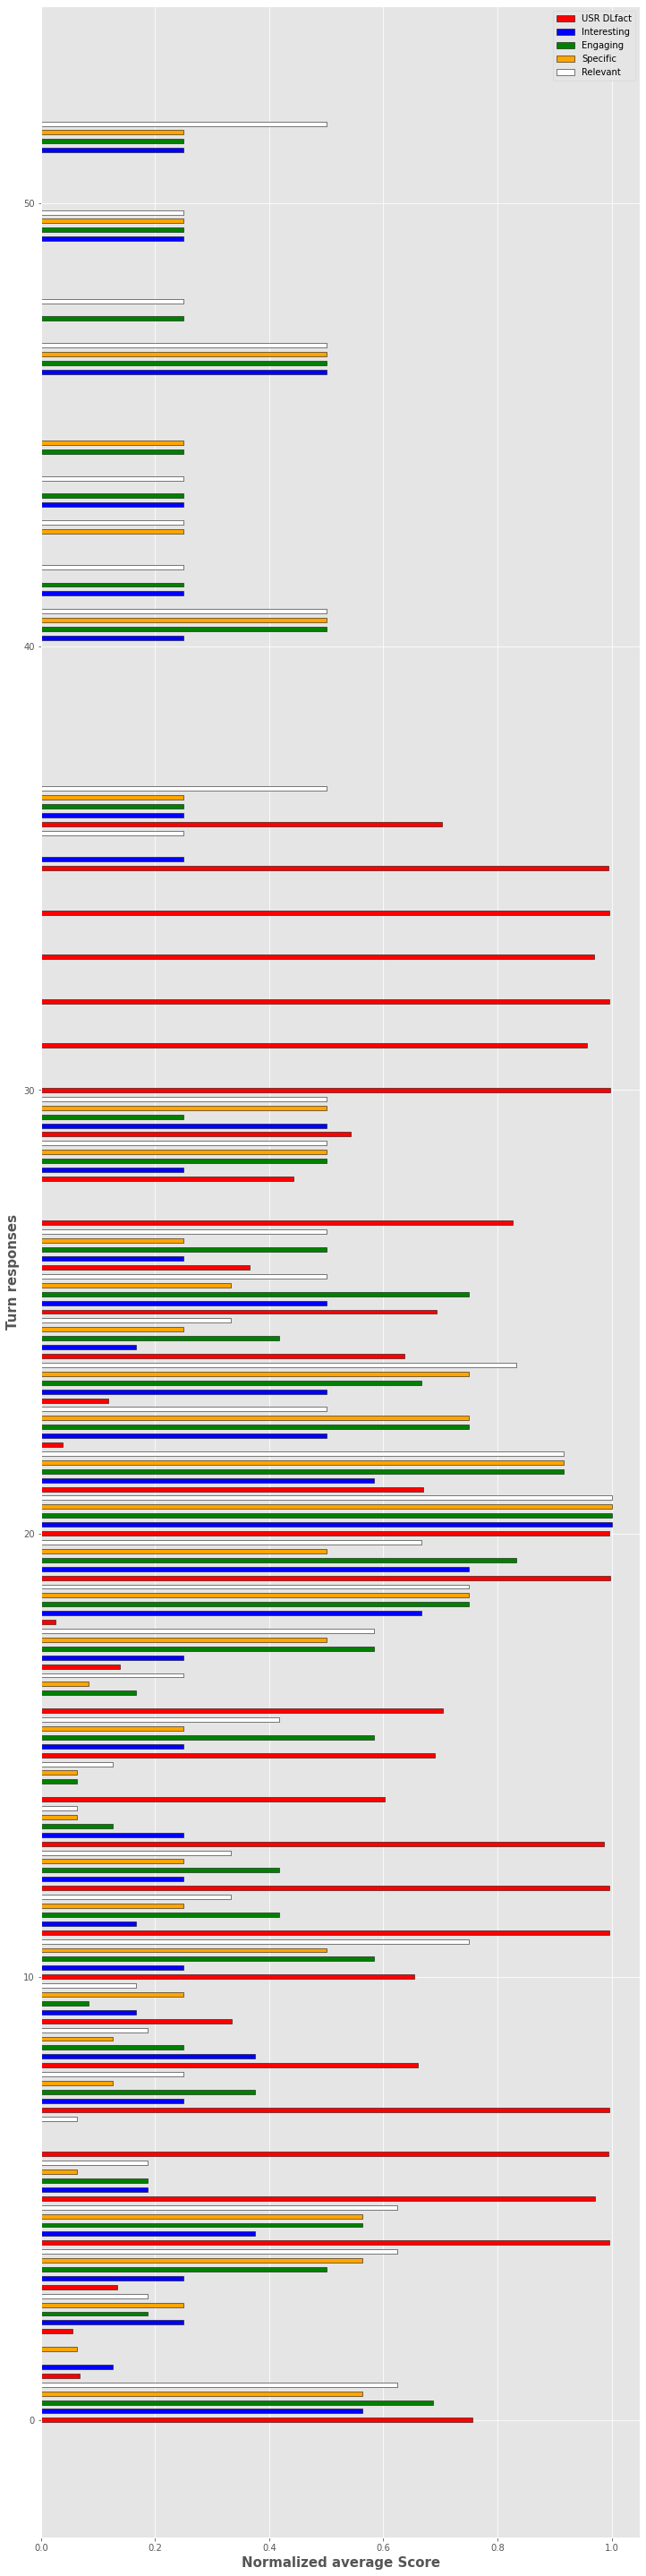

In [46]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

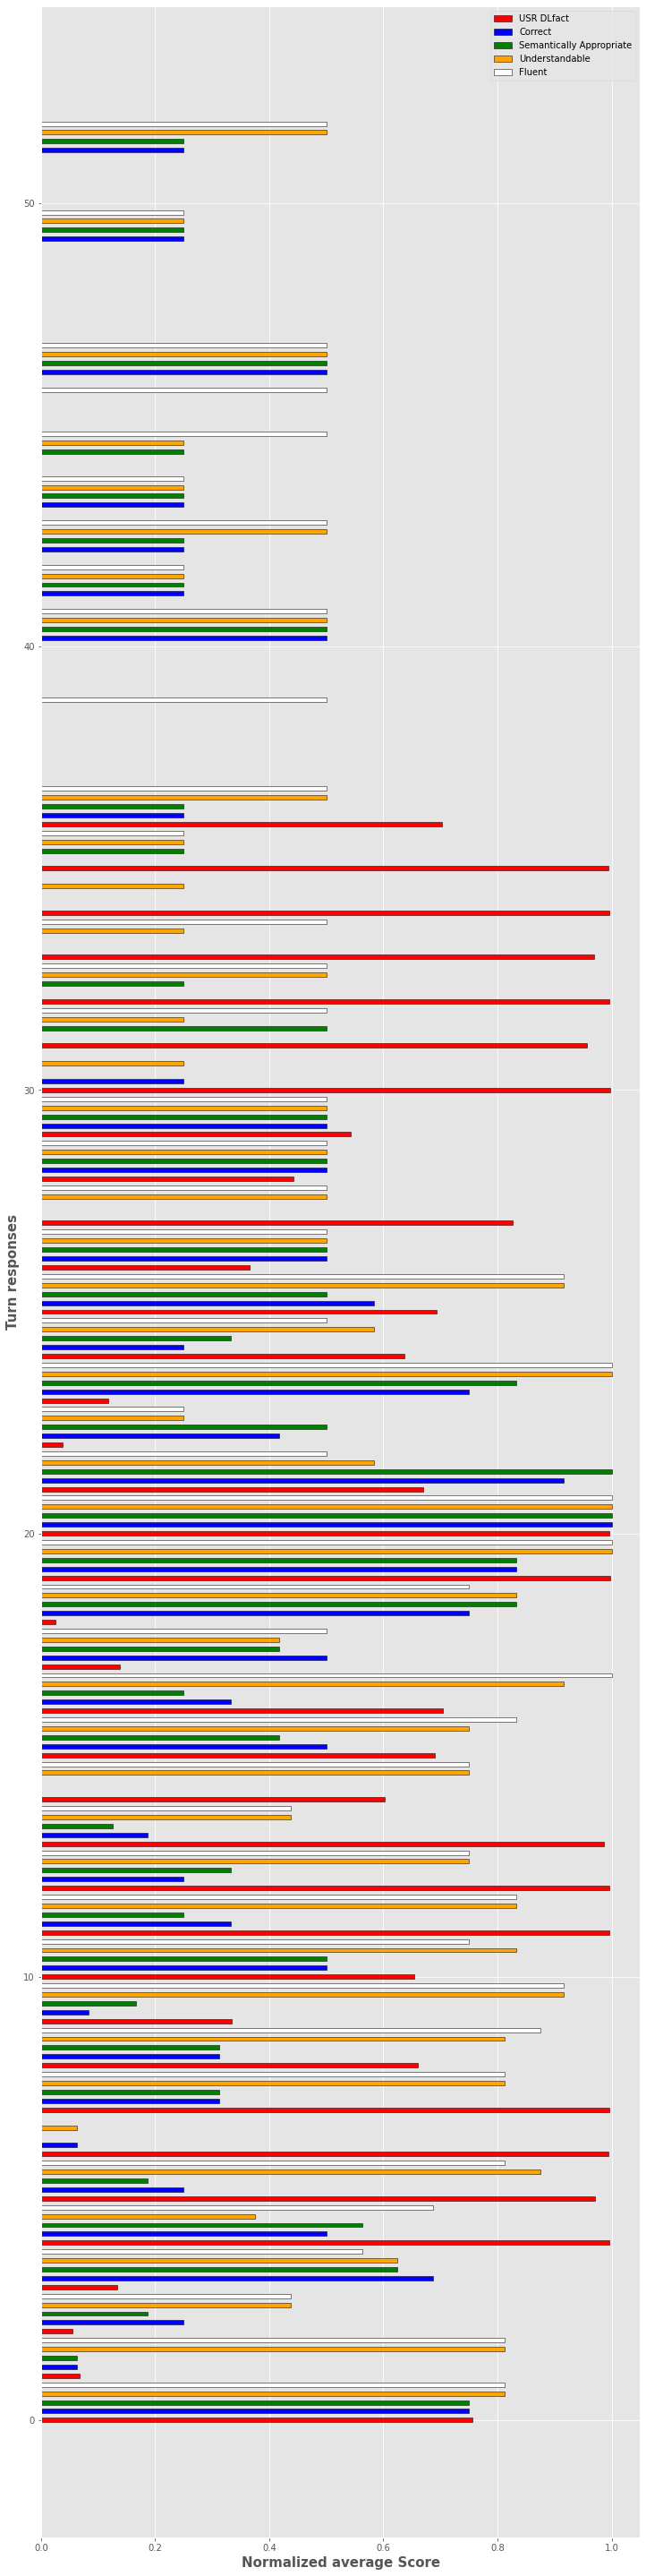

In [47]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [48]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

## End of notebook